In [36]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np

In [37]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torch.utils.data
import gc
import resource
print(torch.__version__)

0.4.1


In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


In [39]:
batch_size = 256
num_classes = 100
nb_classes = 20
epochs = 50
learning_rate = 3e-4
from keras.datasets import cifar100
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = cifar100.load_data('coarse')
(Xf_train, yf_train), (Xf_test, yf_test) = cifar100.load_data('fine')

# print shape of data while model is building
print("{1} train samples, {2} channel{0}, {3}x{4}".format("" if X_train.shape[1] == 1 else "s", *X_train.shape))
print("{1}  test samples, {2} channel{0}, {3}x{4}".format("" if X_test.shape[1] == 1 else "s", *X_test.shape))

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# convert class vectors to binary class matrices
Yf_train = np_utils.to_categorical(yf_train, num_classes)
Yf_test = np_utils.to_categorical(yf_test, num_classes)

Using TensorFlow backend.


50000 train samples, 32 channels, 32x3
10000  test samples, 32 channels, 32x3


In [40]:
tensor_x_train = torch.Tensor(X_train).permute(0,3,1,2)
tensor_x_test = torch.Tensor(X_test).permute(0,3,1,2)
tensor_yc_train = torch.LongTensor(y_train.flatten())
tensor_yf_train = torch.LongTensor(yf_train.flatten())
print(tensor_x_train.shape)
print(tensor_x_test.shape)
print(tensor_yc_train.shape)
print(tensor_yf_train.shape)


torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
torch.Size([50000])
torch.Size([50000])


In [41]:
tensor_yc_test = torch.LongTensor(y_test.flatten())
tensor_yf_test = torch.LongTensor(yf_test.flatten())
print(tensor_x_test.shape)
print(tensor_yc_test.shape)
print(tensor_yf_test.shape)


torch.Size([10000, 3, 32, 32])
torch.Size([10000])
torch.Size([10000])


In [42]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_yc_train,tensor_yf_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_test,tensor_yc_test,tensor_yf_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [43]:
print(len(train_loader))
print(len(val_loader))

196
40


In [49]:
import math
import torch
from torch.optim import Optimizer


class Adam(Optimizer):
    """Implements Adam algorithm.

    It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
    
    def step(self, alpha, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = alpha * group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [50]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) #32*32*32
        self.conv2 = nn.Conv2d(32, 32, 3, padding=0) #32*32*32
        self.pool = nn.MaxPool2d(2, 2) #14*14*6
        self.dropout = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) #32*32*32
        self.conv4 = nn.Conv2d(64, 64, 3, padding=0) #32*32*32
        self.fc1 = nn.Linear(2304, 512)
        self.dropout1d = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 20)
        self.fc3 = nn.Linear(512, 100)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = self.dropout(self.pool(F.relu(self.conv4(x))))
        x = x.view(-1, self.num_flat_features(x)) #16 * 5 * 5
        x = self.dropout1d(self.fc1(x))
        y = self.softmax(self.fc2(x))
        z = self.softmax(self.fc3(x))
        return y,z
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

for i in net.parameters():
    print(i.shape)
    
summary(net, (3, 32, 32))

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([512, 2304])
torch.Size([512])
torch.Size([20, 512])
torch.Size([20])
torch.Size([100, 512])
torch.Size([100])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 32, 30, 30]           9,248
         MaxPool2d-3           [-1, 32, 15, 15]               0
         Dropout2d-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]          18,496
            Conv2d-6           [-1, 64, 13, 13]          36,928
         MaxPool2d-7             [-1, 64, 6, 6]               0
         Dropout2d-8             [-1, 64, 6, 6]               0
            Linear-9                  [-1, 512]       1,180,16

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
import torch
torch.manual_seed(1337)

# Loss and Optimizer

#Can also try nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer1 = Adam([i for i in net.parameters() if i.shape != torch.Size([100]) and i.shape != torch.Size([100, 200])], lr=learning_rate, weight_decay=0.03)
optimizer2 = Adam([i for i in net.parameters() if i.shape != torch.Size([20]) and i.shape != torch.Size([20, 200])], lr=learning_rate, weight_decay=0.03)

train_acc = []
val_acc = []
trainc_acc = []
valc_acc = []
trainf_acc = []
valf_acc = []

loss_history = []
lossc_history = []
lossf_history = []

for epoch in range(epochs):
    for i, (images, labelc, labelf) in enumerate(train_loader):
        net.train() # Change model to 'train' mode.
    #     for i in range(cnn_training_data_X.shape[0]):
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
    #     print images.shape
        labelc = Variable(labelc, requires_grad=False)
        labelf = Variable(labelf, volatile=True)
        #labels = [labelc, labelf]

        # Forward + Backward + Optimize
        net.zero_grad()
        #outputs = net(images)
        
        
        outc, outf = net(images)
        lossc = criterion(outc, labelc)
        lossf = criterion(outf, labelf)
        loss = lossc + lossf
        
        alpha_ = lossf/(lossc+lossf)
        
        #loss = criterion(outputs, labelc)
        #loss.backward()
        
        loss_history.append(loss.data)
        lossc_history.append(lossc.data)
        lossf_history.append(lossf.data)
        
        loss.backward()
        
        
        optimizer1.step(alpha=alpha_.data)
        optimizer2.step(alpha=(1-alpha_.data))
        
        #for f in net.parameters():
            #if f.shape != torch.Size([100]) and f.shape != torch.Size([100, 200]):
            #f.data.sub_(f.grad.data * learning_rate)
        if (i+1) % 20 == 0:
            print(alpha_.data)
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, %.4f, %.4f' 
                   %(epoch+1, epochs, i+1, len(X_train.shape)//batch_size, lossc.data, lossf.data,loss.data))
    print('[%d/%d] Loss: %.3f' % (epoch+1, epochs, np.mean(loss_history)))
    
    
    correctc = 0
    correctf = 0
    total = 0
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    with torch.no_grad():
        for data in train_loader:
            images, labelc, labelf = data
            outputc, outputf = net(images)
            _, predictedc = torch.max(outputc.data, 1)
            _, predictedf = torch.max(outputf.data, 1)
            total += labelc.size(0)
            correctc += (predictedc == labelc).sum().item()
            correctf += (predictedf == labelf).sum().item()
    print(total)
    trainc_acc_val = (100 * correctc / total)
    trainf_acc_val = (100 * correctf / total)
    train_acc_val = (trainc_acc_val + trainf_acc_val)/2.0
    trainc_acc.append(trainc_acc_val)
    trainf_acc.append(trainf_acc_val)
    train_acc.append(train_acc_val)
    print('Accuracy of the network on the 50000 train images coarse: %d %%' % (trainc_acc_val))
    print('Accuracy of the network on the 50000 train images fine: %d %%' % (trainf_acc_val))
    print('Average Accuracy of the network on the 50000 train images: %d %%' % (train_acc_val))
          
    correctc = 0
    correctf = 0
    total = 0
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    with torch.no_grad():
        for data in val_loader:
            images, labelc, labelf = data
            outputc, outputf = net(images)
            _, predictedc = torch.max(outputc.data, 1)
            _, predictedf = torch.max(outputf.data, 1)
            total += labelc.size(0)
            correctc += (predictedc == labelc).sum().item()
            correctf += (predictedf == labelf).sum().item()

    valc_acc_val = (100 * correctc / total)
    valf_acc_val = (100 * correctf / total)
    val_acc_val = (valc_acc_val + valf_acc_val)/2.0
    valc_acc.append(valc_acc_val)
    valf_acc.append(valf_acc_val)
    val_acc.append(val_acc_val)
    print('Accuracy of the network on the 10000 test images coarse: %d %%' % (valc_acc_val))
    print('Accuracy of the network on the 10000 test images fine: %d %%' % (valf_acc_val))
    print('Average Accuracy of the network on the 10000 test images: %d %%' % (val_acc_val))

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:29: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.6049)
Epoch [1/50], Iter [20/0] Loss: 3.0049, 4.6012, 7.6061
tensor(0.6068)
Epoch [1/50], Iter [40/0] Loss: 2.9793, 4.5970, 7.5763
tensor(0.6073)
Epoch [1/50], Iter [60/0] Loss: 2.9718, 4.5967, 7.5685
tensor(0.6091)
Epoch [1/50], Iter [80/0] Loss: 2.9430, 4.5866, 7.5296
tensor(0.6092)
Epoch [1/50], Iter [100/0] Loss: 2.9432, 4.5882, 7.5314
tensor(0.6107)
Epoch [1/50], Iter [120/0] Loss: 2.9217, 4.5833, 7.5051
tensor(0.6080)
Epoch [1/50], Iter [140/0] Loss: 2.9582, 4.5884, 7.5466
tensor(0.6098)
Epoch [1/50], Iter [160/0] Loss: 2.9397, 4.5937, 7.5335
tensor(0.6096)
Epoch [1/50], Iter [180/0] Loss: 2.9433, 4.5954, 7.5387
[1/50] Loss: 7.548
50000
Accuracy of the network on the 50000 train images coarse: 15 %
Accuracy of the network on the 50000 train images fine: 3 %
Average Accuracy of the network on the 50000 train images: 9 %
Accuracy of the network on the 10000 test images coarse: 15 %
Accuracy of the network on the 10000 test images fine: 3 %
Average Accuracy of the network o

tensor(0.6147)
Epoch [9/50], Iter [20/0] Loss: 2.8565, 4.5569, 7.4134
tensor(0.6145)
Epoch [9/50], Iter [40/0] Loss: 2.8692, 4.5740, 7.4432
tensor(0.6130)
Epoch [9/50], Iter [60/0] Loss: 2.8831, 4.5663, 7.4495
tensor(0.6145)
Epoch [9/50], Iter [80/0] Loss: 2.8712, 4.5765, 7.4477
tensor(0.6129)
Epoch [9/50], Iter [100/0] Loss: 2.8922, 4.5789, 7.4711
tensor(0.6115)
Epoch [9/50], Iter [120/0] Loss: 2.9029, 4.5694, 7.4722
tensor(0.6108)
Epoch [9/50], Iter [140/0] Loss: 2.9210, 4.5836, 7.5047
tensor(0.6103)
Epoch [9/50], Iter [160/0] Loss: 2.8959, 4.5347, 7.4305
tensor(0.6123)
Epoch [9/50], Iter [180/0] Loss: 2.8903, 4.5640, 7.4543
[9/50] Loss: 7.484
50000
Accuracy of the network on the 50000 train images coarse: 19 %
Accuracy of the network on the 50000 train images fine: 5 %
Average Accuracy of the network on the 50000 train images: 12 %
Accuracy of the network on the 10000 test images coarse: 18 %
Accuracy of the network on the 10000 test images fine: 5 %
Average Accuracy of the network 

[35.5]


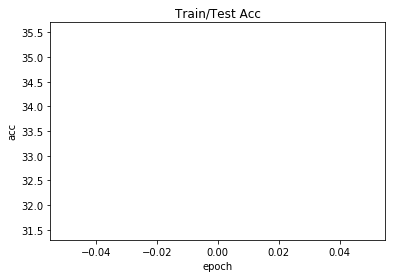

In [168]:
#plot train/val accuracies
print(train_acc)
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
plt.plot(train_acc, color='red')
plt.plot(val_acc, color='blue')
plt.show()